In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Callable
from itertools import product

from simulation.utils.functions import get_cost_matrix
from simulation.solver.matching import (
    composite_sequential_matching,
    k_hungarian_matching,
    k_hungarian_capacity_exhaust,
    k_hungarian_m_capacity_exhaust
)

from simulation.solver.matching.random_process import k_hungarian_capacity_exhaust_random, k_hungarian_m_capacity_exhaust_random

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [3]:
PATH = 'simulation/tests/_data/sample_snapshot_2.parquet'
# dist_matrix = get_cost_matrix(PATH, 0.5)

In [4]:
ms = list(range(1, 16))
cs = list(range(1, 16))
drs = [10.0]
fracs = [0.0, 0.2, 0.4, 0.6, 0.8, 0.95]
funcs = [k_hungarian_capacity_exhaust, k_hungarian_m_capacity_exhaust]
comb = list(product(ms, cs, drs, fracs, funcs))
columns = ['m', 'capacity', 'dr', 'dropout', 'func']
comb_df = pd.DataFrame([{k: v for k, v in zip(columns, x)} for x in comb])

In [5]:
def f(matrix: np.ndarray, m: int, capacity: int, dr: float, matching_fn: Callable, save: bool = False) -> None:
    assignments = matching_fn(matrix, m, capacity, dr)
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    data = pd.DataFrame({'customer_id': range(assignments.shape[0]), 'cnt_assigned': assignments.sum(axis=1)})
    a = sns.barplot(data, x='customer_id', y='cnt_assigned', ax=axes[0])
    a.get_xaxis().set_visible(False)
    a.set_title(
        f'Customers side. Idle clients: {round((len(np.where(assignments.sum(axis=1) == 0.0)[0])/matrix.shape[1])*100, 2)} %'
    )
    
    data = pd.DataFrame({'captain_id': range(assignments.shape[1]), 'cnt_assigned': assignments.sum(axis=0)})
    b = sns.barplot(data, x='captain_id', y='cnt_assigned', ax=axes[1])
    b.get_xaxis().set_visible(False)
    b.set_title(
        f'Captains side. Idle captains: {round((len(np.where(assignments.sum(axis=0) == 0.0)[0])/matrix.shape[1])*100, 2)} %'
    )
    
    if save:
        plt.savefig(f'{matching_fn.__name__}_choice.png', bbox_inches='tight', pad_inches=0.5)

In [15]:
params = dict(
    m=7,
    capacity=5,
    dr=15.0,
)

cost_matrix = get_cost_matrix(PATH, dropout=0.5)
cost_matrix.shape

(130, 137)

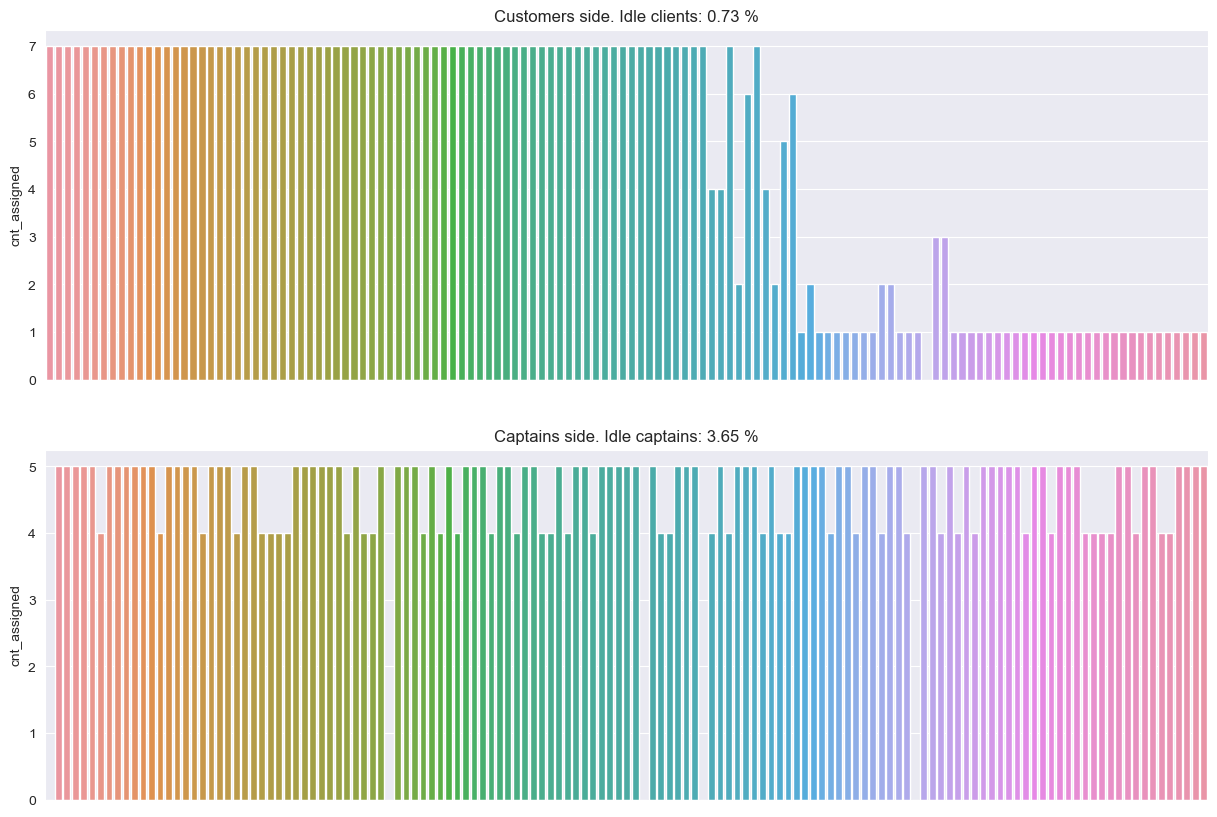

In [16]:
f(matrix=cost_matrix, matching_fn=composite_sequential_matching, **params, save=True)

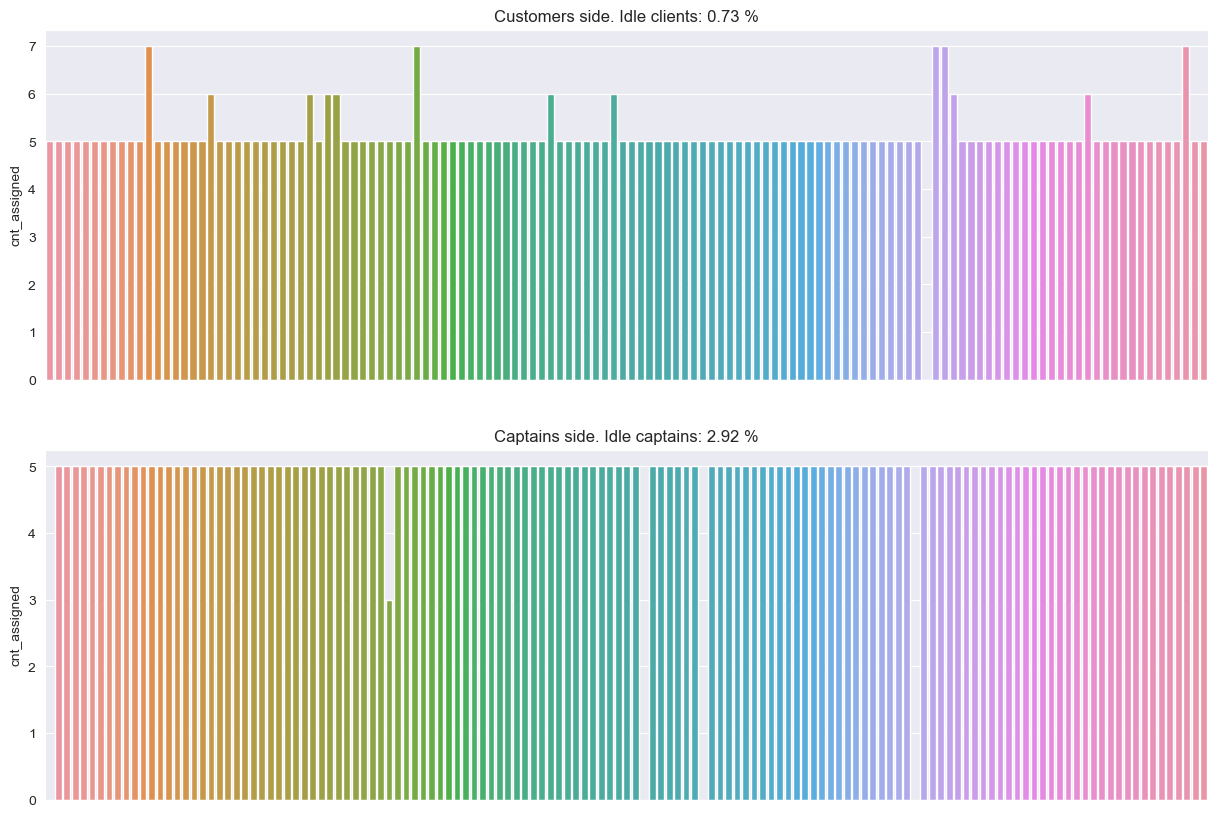

In [17]:
f(matrix=cost_matrix, matching_fn=k_hungarian_m_capacity_exhaust, **params, save=True)

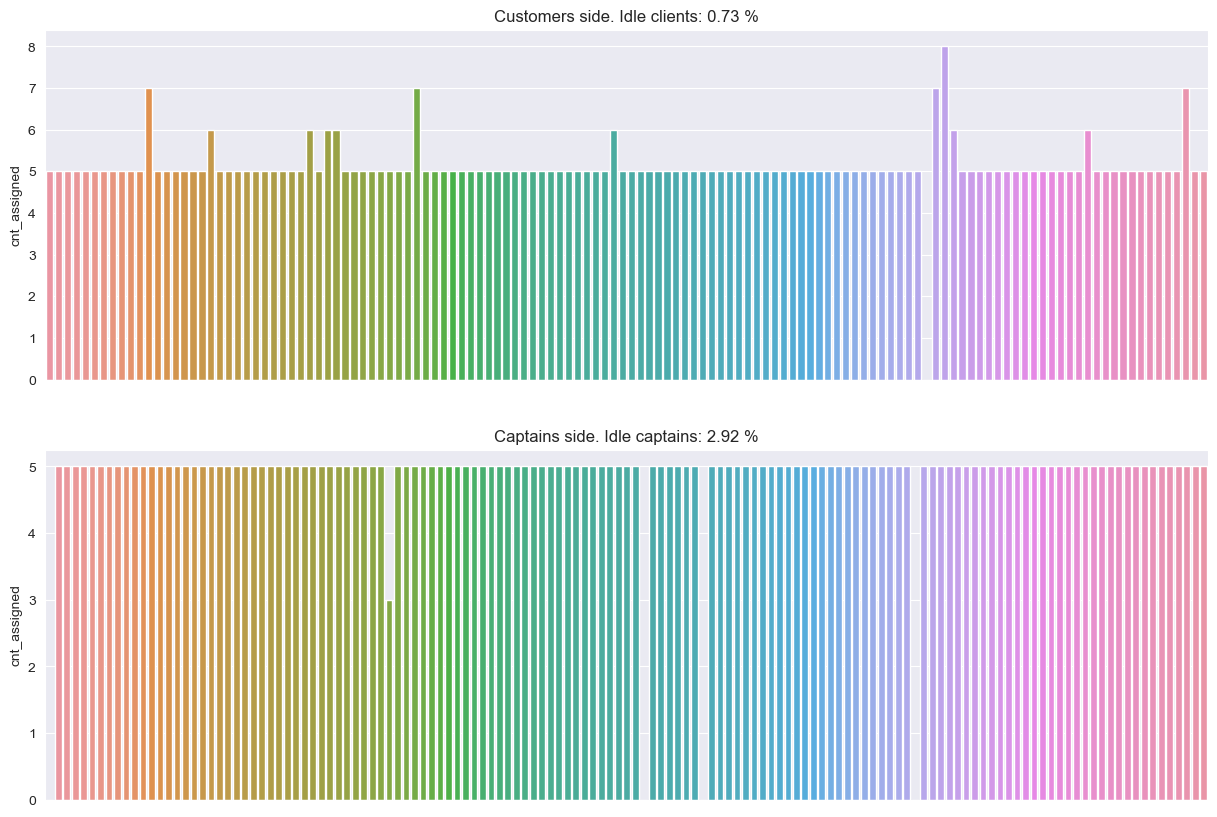

In [18]:
f(matrix=cost_matrix, matching_fn=k_hungarian_capacity_exhaust, **params)